## Fixed Data:

In [31]:
pip install fredapi

Note: you may need to restart the kernel to use updated packages.


In [1]:
import json
import numpy as np
import requests
import pandas as pd
from fredapi import Fred

API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

symbolListShort = ['BTC', 'ETH', 'LTC']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'TransactionCount': '/v1/metrics/transactions/count',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

In [2]:
fred = Fred(api_key=FRED_API_KEY)
Risk_free_rate = fred.get_series('DGS1MO', frequency = 'w')
Risk_free_rate = Risk_free_rate.to_frame()
Risk_free_rate = Risk_free_rate.reset_index()
Risk_free_rate = Risk_free_rate.rename(columns={'index':'Date', 0:'RiskFree'})

In [3]:
Risk_free_rate.tail()

,Date,RiskFree
1079,2022-04-08,0.20
1080,2022-04-15,0.27
1081,2022-04-22,0.41
1082,2022-04-29,0.38
1083,2022-05-06,NaN


## Get Multiple Attributes for Multiple Coins:

In [4]:
### Define a function to pull data according to input values(coin, feature)
### After running this method, it should return pulled data, and also store it in memory named as "coin_feature"

def PullData(coin, feature):
    ##print(f"Pulling {coin}'s {feature} data")

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin, 'api_key': API_KEY, 'i':'1w'})
    data_raw = pd.read_json(res.text, convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v" : f"{feature}", 't':'Date'})

    # Turn renamed dataframe into a global variable for future using
    name = f"{coin}_{feature}"
    globals()[name] = data

    # Return a dataframe
    return data

In [5]:
### Get all features(listed in endPoints) of all coins(listed in symbolListShort) 

from functools import reduce

for i in symbolList:
    ##print(f"Start Pulling {i}'s data:")

    # Preparation for merging
    frameName = f"{i}_Frames"
    locals()[frameName] = []

    # Get data
    for j in list(endPoints.keys()):
        locals()[frameName].append(PullData(i, j))

    # Merge to single dataframe
    ##print('Merging Dataframes...')
    dfName = f"{i}_Raw"
    locals()[dfName] = reduce(lambda  left,right: pd.merge(left,right, on='Date', how='inner'), locals()[frameName])
    locals()[dfName] = locals()[dfName].merge(Risk_free_rate, on='Date', how='left')

    ##print(f"{i} data successfully pulled\n")
##print('\nALL DATA SUCCESSFULLY PULLED!')

# NET: Network Factor

## Get address growth

In [13]:
NET = pd.DataFrame({'Date':[]})
NET.Date = BTC_Raw.Date

for i in symbolList:
    dfName = f"{i}_Raw"

    copy1 = f"{i}1"
    locals()[copy1] = locals()[dfName].copy()
    copy2 = f"{i}2"
    locals()[copy2] = locals()[dfName].copy()
    locals()[copy2] = locals()[copy2].shift()

    df_NET = f"{i}_NET"
    locals()[df_NET] = pd.DataFrame({'Date':[],f"{i}":[]})
    locals()[df_NET]['Date'] = locals()[copy1]['Date']
    locals()[df_NET][f"{i}"] = np.log(locals()[copy1]['ActiveAddress'])-np.log(locals()[copy2]['ActiveAddress'])


    NET = NET.merge(locals()[df_NET], left_on='Date', right_on='Date', how='outer')
    
NET['30Percentile'] = NET.quantile(q=0.3, numeric_only= True, axis = 1)
NET['70Percentile'] = NET.quantile(q=0.7, numeric_only= True, axis = 1)

C:\ZacharyYang\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [48]:
NET.tail()

,Date,BTC,ETH,LTC,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,...,WAX,WBTC,WETH,wNXM,WTC,YAM,YFI,ZRX,30Percentile,70Percentile
611,2022-03-28,0.029004,-0.838423,0.033521,-0.622188,-0.656780,-0.689544,-1.625967,-1.167241,-1.073733,...,NaN,-0.639724,-0.574962,-0.715126,-1.098612,-1.098612,-0.600077,-0.652200,-0.921058,-0.636794
612,2022-04-04,-0.070992,0.634692,0.006797,0.382879,0.538997,0.656513,1.252763,0.651300,0.727796,...,NaN,0.571381,0.537376,0.773190,1.098612,0.000000,0.646390,0.430304,0.428622,0.727796
613,2022-04-11,0.012006,0.011861,0.046824,-0.070626,1.011601,0.003724,0.112478,-0.043675,-0.179230,...,NaN,-0.004466,-0.024533,0.268264,-inf,0.000000,-0.151977,-0.014118,-0.161771,0.027857
614,2022-04-18,0.017513,0.089242,-0.056119,-0.147586,-1.098612,0.268920,-0.021506,-0.018019,-0.107420,...,NaN,-0.075206,0.100333,-0.288990,inf,-inf,-0.236659,0.585678,-0.168773,0.088810
615,2022-04-25,0.052567,-0.080082,-0.038385,0.060475,0.342945,-0.064539,3.307842,0.009050,-0.063851,...,NaN,0.027366,0.028766,-0.177100,NaN,inf,0.024098,-0.291501,-0.144668,0.058414


## Get Return

In [44]:
Return = pd.DataFrame({'Date':[]})
Return['Date'] = NET.Date
for i in symbolList:
    
    dfName = f"{i}_Raw" 
    df = f"{i}_Return"
    locals()[df] = pd.DataFrame({'Date':[]})
    locals()[df].Date = locals()[dfName].Date
    locals()[df][f"{i}"] = locals()[dfName].Price.rolling(52).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0])

    Return = Return.merge(locals()[df], left_on='Date', right_on='Date', how='outer')

In [45]:
Return.tail()

,Date,BTC,ETH,LTC,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,...,VERI,WaBi,WAX,WBTC,WETH,wNXM,WTC,YAM,YFI,ZRX
611,2022-03-28,-0.228895,0.631835,-0.491746,-0.348106,-0.477305,0.084185,-0.472280,-0.964101,-0.706981,...,2.806782,-0.824035,NaN,-0.225938,0.639689,-0.395349,-0.736324,-0.925272,-0.441637,-0.574214
612,2022-04-04,-0.247393,0.441735,-0.592545,-0.532297,-0.494609,-0.102967,-0.475536,-0.971910,-0.743336,...,1.819913,-0.783747,NaN,-0.247720,0.438419,-0.478550,-0.729609,-0.925156,-0.616723,-0.567780
613,2022-04-11,-0.189989,0.294148,-0.513018,-0.516923,-0.226491,-0.069950,-0.462487,-0.969005,-0.650726,...,1.315011,-0.715514,NaN,-0.191549,0.300469,-0.619835,-0.659522,-0.892947,-0.529411,-0.487158
614,2022-04-18,-0.302532,-0.010142,-0.611058,-0.655426,-0.356398,0.116001,-0.558497,-0.975292,-0.762670,...,1.761850,-0.839186,NaN,-0.300376,-0.003206,-0.673461,-0.749220,-0.911866,-0.621322,-0.567022
615,2022-04-25,-0.339032,-0.280520,-0.742114,-0.680781,-0.425095,-0.133190,-0.665187,-0.982596,-0.780041,...,0.709296,-0.866380,NaN,-0.340539,-0.268883,-0.768938,NaN,-0.905282,-0.678712,-0.633263


## Construct Network factor

In [58]:
C5 = pd.DataFrame({'Date':[]})
C5.Date = NET.Date
C5['short'] = Return[NET[symbolList].apply(lambda x: x <= NET['30Percentile'])].mean(axis=1, numeric_only= True)
C5['long'] = Return[NET[symbolList].apply(lambda x: x >= NET['70Percentile'])].mean(axis=1, numeric_only= True)
C5['NET'] = C5.long - C5.short
C5.drop(columns=['short', 'long'], inplace=True)
C5.tail()

,Date,NET
611,2022-03-28,-0.328270
612,2022-04-04,0.256623
613,2022-04-11,-0.035431
614,2022-04-18,-0.009535
615,2022-04-25,0.052962


## Verification

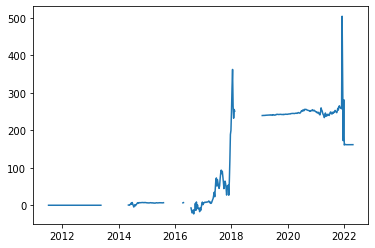

In [60]:
import matplotlib.pyplot as plt

plt.plot(C5.Date, np.cumsum(C5.NET))